In [141]:
import re, math, collections, itertools, os
import nltk, nltk.classify.util, nltk.metrics
from nltk.classify import NaiveBayesClassifier
from nltk.metrics import BigramAssocMeasures
from nltk.probability import FreqDist, ConditionalFreqDist
from nltk import precision,recall
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import io
import hashlib
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import json
import os

In [142]:
path = 'manual_labels_context'
print('subdirectories are:' + str(os.listdir(path)))
def get_files(path):
    return sorted([path+ os.sep +f for f in os.listdir(path) if f.endswith(".txt")])

subdirectories are:['.DS_Store', 'test', 'train']


In [143]:
categories = ['F', 'S','A']

In [144]:
F_train_files = get_files(path + os.sep + 'train' + os.sep + 'F')
A_train_files = get_files(path  + os.sep + 'train' +  os.sep + 'A')
S_train_files = get_files(path  + os.sep + 'train' +  os.sep + 'S')
all_train_files = F_train_files + A_train_files + S_train_files
needed_train_files = F_train_files
not_needed_train_files = S_train_files + A_train_files  

F_test_files = get_files(path  + os.sep + 'test' + os.sep + 'F')
A_test_files = get_files(path  + os.sep + 'test' + os.sep + 'A')
S_test_files = get_files(path  + os.sep + 'test' +  os.sep + 'S')
all_test_files = F_test_files + A_test_files + S_test_files 
needed_test_files = F_test_files 
not_needed_test_files = S_test_files + A_test_files  


print('found %d FoodOnly,%d ServiceOnly,%d AmbienceOnly training files' %
      (len(F_train_files), len(S_train_files),len(A_train_files)))

print('found %d FoodOnly,%d ServiceOnly,%d AmbienceOnly testing files' %
      (len(F_test_files), len(S_test_files),len(A_test_files)))


found 46 FoodOnly,5 ServiceOnly,3 AmbienceOnly training files
found 16 FoodOnly,2 ServiceOnly,1 AmbienceOnly testing files


In [145]:
def get_true_labels(file_names):
    labels = []
    for f in file_names:
        if '/F' in f:
            labels.append(1)
        else:
            labels.append(0)
    return np.array(labels)

labels = get_true_labels(all_train_files)
print('first 3 and last 3 labels are: %s' % str(labels[[1,2,3,-3,-2,-1]]))

first 3 and last 3 labels are: [1 1 1 0 0 0]


In [146]:
train_data = []
for F_file in F_train_files:
    with open(F_file, 'r') as content_file:
        content = content_file.read()
    train_data.append((unicode(content, 'unicode-escape'),'F'))
    
for S_file in S_train_files:
    with open(S_file, 'r') as content_file:
        content = content_file.read()
    train_data.append((unicode(content, 'unicode-escape'),'S'))
    
for A_file in A_train_files:
    with open(A_file, 'r') as content_file:
        content = content_file.read()
    train_data.append((unicode(content, 'unicode-escape'),'A'))

In [147]:
test_data = []
for F_file in F_test_files:
    with open(F_file, 'r') as content_file:
        content = content_file.read()
    test_data.append((unicode(content, 'unicode-escape'),'F'))
    
for S_file in S_test_files:
    with open(S_file, 'r') as content_file:
        content = content_file.read()
    test_data.append((unicode(content, 'unicode-escape'),'S'))
    
for A_file in A_test_files:
    with open(A_file, 'r') as content_file:
        content = content_file.read()
    test_data.append((unicode(content, 'unicode-escape'),'A'))

In [148]:
print("Total no of train files are:",len(all_train_files))
print("Total no of test files are:",len(all_test_files))

('Total no of train files are:', 54)
('Total no of test files are:', 19)


In [149]:
train_file_data = [open(fil).read() for fil in all_train_files]
test_file_data = [open(fil).read() for fil in all_test_files]

In [150]:
def file2string(filename):
    return io.open(filename, encoding='utf8').readlines()[0]
    
file2string(all_train_files[20])

u"Overpriced. The xiao long baos price are double compare to the ones in Chinatown, and the taste really cant' compare with Joe's shanghai, really nothing to raved about if you have tried shanghainese food in other places."

In [151]:
def tokenize(text):
    return filter(None,re.split(r"[\W]",text.lower()))

In [152]:
def tokenize_with_punct(text):
    tokens = re.findall(r"\w+|\S", text.lower(),flags = re.L)
    return [t.encode('utf-8').decode('utf-8').encode('utf-8') for t in tokens]

In [153]:
def tokenize_with_not(text):
    tokens = tokenize_with_punct(text)
    for i,token in enumerate(tokens):
        if (token == 'not'):
            if (i+1 <= len(tokens)-1):
                tokens[i+1] = token + '_' + tokens[i+1]
            if (i+2 <= len(tokens)-1):
                tokens[i+2] = token + '_' + tokens[i+2]
    return tokens

In [154]:
def do_vectorize(filenames, tokenizer_fn=tokenize, min_df=1,
                 max_df=1., binary=True,stop_words=None, ngram_range=(1,1)):
    if type(filenames) is np.ndarray:
        filenames = filenames.tolist()
    vec = CountVectorizer(input='content',tokenizer=tokenizer_fn, min_df=min_df,
                 max_df=max_df, binary=binary, ngram_range=ngram_range,stop_words=stop_words)
    data  = []
    for fil in filenames:
        f = open(fil, 'r')
        data.append(unicode(f.read(), 'unicode-escape'))
    return vec.fit_transform(data),vec
    
matrix, vec = do_vectorize(all_train_files)
print ('matrix represents %d documents with %d features' % (matrix.shape[0], matrix.shape[1]))
print('first doc has terms:\n%s' % (str(sorted(matrix[0].nonzero()[1]))))

matrix represents 54 documents with 1222 features
first doc has terms:
[26, 34, 38, 43, 47, 50, 54, 56, 58, 59, 78, 89, 92, 111, 118, 121, 128, 141, 152, 155, 161, 163, 176, 185, 195, 203, 205, 218, 270, 271, 315, 324, 325, 326, 350, 412, 414, 422, 424, 437, 444, 454, 476, 488, 504, 512, 518, 533, 535, 547, 581, 589, 592, 612, 653, 654, 663, 667, 672, 677, 682, 694, 713, 732, 741, 773, 774, 834, 853, 868, 923, 956, 1007, 1027, 1050, 1051, 1052, 1053, 1060, 1067, 1079, 1091, 1098, 1117, 1133, 1168, 1172, 1174, 1181, 1185, 1189, 1194, 1197, 1216]


In [155]:
print vec.get_feature_names()

[u'1', u'10', u'11', u'1130am', u'11am', u'11pm', u'12', u'14', u'15', u'2', u'20', u'20mins', u'21', u'24', u'25', u'2nd', u'3', u'30', u'4', u'5', u'50', u'5pm', u'6', u'75', u'8', u'95', u'a', u'a4', u'able', u'about', u'act', u'activity', u'actual', u'actually', u'added', u'addition', u'adjacent', u'affordable', u'after', u'again', u'ago', u'agree', u'ahead', u'air', u'airport', u'aka', u'al', u'all', u'almost', u'already', u'also', u'although', u'always', u'am', u'amazing', u'ambiance', u'americanized', u'amount', u'an', u'and', u'annoying', u'another', u'answer', u'answered', u'any', u'anymore', u'anyone', u'anything', u'anyway', u'apart', u'appeals', u'appetite', u'appetizer', u'appetizers', u'approachable', u'are', u'area', u'areas', u'around', u'array', u'arrive', u'arrived', u'arriving', u'arse', u'as', u'asian', u'aside', u'asked', u'assuming', u'at', u'ate', u'attentive', u'authentic', u'authenticity', u'average', u'away', u'aways', u'awesome', u'awkward', u'baby', u'back',

In [156]:
def repeatable_random(seed):
    hash = str(seed)
    while True:
        hash = hashlib.md5(hash).digest()
        for c in hash:
            yield ord(c)

def repeatable_shuffle(X, y, filenames):
    r = repeatable_random(42) 
    indices = sorted(range(X.shape[0]), key=lambda x: next(r))
    return X[indices], y[indices], np.array(filenames)[indices]

X, y, filenames = repeatable_shuffle(matrix, labels, all_train_files)

print('first shuffled document %s has label %d and terms: %s' % 
      (filenames[0], y[0], sorted(X[0].nonzero()[1])))

first shuffled document manual_labels_context/train/F/16.txt has label 1 and terms: [26, 41, 59, 70, 84, 161, 168, 205, 230, 304, 305, 323, 340, 374, 385, 412, 414, 443, 454, 458, 460, 476, 488, 492, 512, 518, 533, 535, 542, 554, 571, 580, 601, 610, 654, 659, 685, 694, 725, 729, 738, 756, 785, 854, 856, 857, 858, 868, 900, 909, 912, 952, 956, 958, 1005, 1023, 1027, 1036, 1050, 1051, 1052, 1079, 1101, 1105, 1113, 1114, 1120, 1153, 1176, 1177, 1189, 1195]


In [157]:
def get_clf():
    return LogisticRegression(random_state=42)

In [158]:
def do_cross_validation(X, y, n_folds=5, verbose=False):
    kf = KFold(X.shape[0],n_folds,shuffle=False,random_state=None)
    c = tot =0
    clf = get_clf()
    for k, (train, test) in enumerate(kf):
        clf.fit(X[train], y[train])
        score = accuracy_score(y[test], clf.predict(X[test]))
        if (verbose):
            print "fold", c ,"accuracy=",score
            c+=1
        tot += score
    return (1.* tot)/ n_folds
    
print('average cross validation accuracy=%.4f' %
      do_cross_validation(X, y, verbose=True))

fold 0 accuracy= 0.818181818182
fold 1 accuracy= 0.909090909091
fold 2 accuracy= 0.818181818182
fold 3 accuracy= 1.0
fold 4 accuracy= 0.8
average cross validation accuracy=0.8691


In [159]:
def do_expt(filenames, y, tokenizer_fn=tokenize,
            min_df=1, max_df=1., binary=True,
            ngram_range=(1,1), n_folds=5):
    return do_cross_validation(do_vectorize(filenames.tolist(),binary=binary,tokenizer_fn=tokenizer_fn,min_df=min_df,max_df=max_df)[0], y,n_folds=n_folds)

In [160]:
print('accuracy using default settings: %.4g' % do_expt(filenames, y))

accuracy using default settings: 0.8691


[0.85185185185185186,
 0.86909090909090914,
 0.87333333333333341,
 0.86666666666666681,
 0.84999999999999998,
 0.875,
 0.85999999999999999]

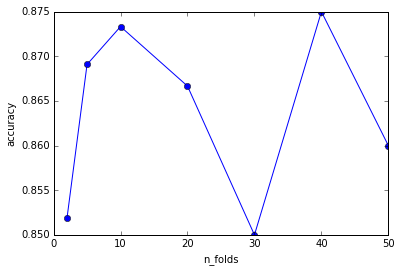

In [161]:
def compare_n_folds(filenames, y):
    arr = [2,5,10,20,30,40,50]
    val = [do_expt(filenames, y,n_folds=i) for i in arr]
    plt.figure()
    plt.xlabel('n_folds')
    plt.ylabel('accuracy')
    plt.plot(arr,val,'bo-')
    return val
    
compare_n_folds(filenames, y)

In [192]:
def compare_binary(filenames, y):
    return [do_expt(filenames, y,binary=True),do_expt(filenames, y,binary=False)]
          
compare_binary(filenames, y)

[0.86909090909090914, 0.88909090909090904]

In [193]:
def tokenizer_expt(all_train_files, y):
    return [do_expt(all_train_files, y,tokenizer_fn=tokenize),do_expt(all_train_files, y,tokenizer_fn=tokenize_with_punct),do_expt(all_train_files, y,tokenizer_fn=tokenize_with_not)]

tokenizer_expt(filenames, y)

[0.86909090909090914, 0.86909090909090914, 0.86909090909090914]

[0.86909090909090914,
 0.86909090909090914,
 0.86909090909090914,
 0.86909090909090914,
 0.88727272727272732,
 0.88727272727272732,
 0.90545454545454551,
 0.90545454545454551,
 0.90545454545454551,
 0.90545454545454551]

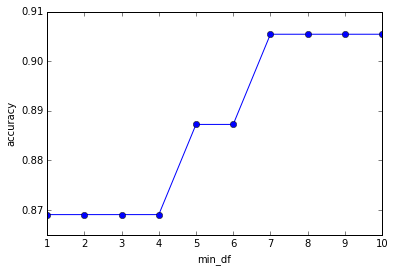

In [194]:
def min_df_expt(filenames, y):
    mindf = range(1,11)
    val = [do_expt(filenames, y,min_df=i,tokenizer_fn=tokenize) for i in mindf]
    plt.figure()
    plt.xlabel('min_df')
    plt.ylabel('accuracy')
    plt.plot(mindf,val,'bo-')
    return val

min_df_expt(filenames, y)

In [195]:
X, vec = do_vectorize(filenames, tokenizer_fn=tokenize,
                      binary=True, min_df=6, max_df=1.)
clf = get_clf()
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0)

In [196]:
print type(clf.coef_)
print clf.coef_.shape

<type 'numpy.ndarray'>
(1, 146)


In [197]:
X_test = vec.transform(all_test_files)
y_test = np.array([1] * len(needed_test_files) + [0] * len(not_needed_test_files))
print('X_test represents %d documents with %d features' % (X_test.shape[0], X_test.shape[1]))
print('y_test has %d positive and %d negative labels' % (len(np.where(y_test==1)[0]),
                                                          len(np.where(y_test==0)[0])))
print('first testing file is %s' % all_test_files[0])
print('last testing file is %s' % all_test_files[-1])
print('testing accuracy=%.10g' % accuracy_score(y_test, clf.predict(X_test)))

X_test represents 19 documents with 146 features
y_test has 16 positive and 3 negative labels
first testing file is manual_labels_context/test/F/103.txt
last testing file is manual_labels_context/test/S/188.txt
testing accuracy=0.8421052632


In [198]:
def index_of_term(vec, term):
    return vec.get_feature_names().index(term)

index_of_term(vec, 'and')

10

In [199]:
print vec.get_feature_names()

[u'2', u'5', u'6', u'a', u'about', u'after', u'again', u'all', u'also', u'an', u'and', u'are', u'as', u'at', u'back', u'be', u'been', u'best', u'bit', u'but', u'by', u'came', u'chicken', u'chinatown', u'chinese', u'cold', u'come', u'cooked', u'definitely', u'delicious', u'dish', u'dumpling', u'dumplings', u'enough', u'excellent', u'experience', u'first', u'flavor', u'food', u'for', u'fresh', u'from', u'get', u'go', u'good', u'got', u'great', u'had', u'has', u'have', u'here', u'hot', u'i', u'if', u'in', u'inside', u'is', u'it', u'joe', u'just', u'like', u'little', u'long', u'lunch', u'me', u'menu', u'minutes', u'more', u'most', u'much', u'my', u'new', u'next', u'noodles', u'not', u'of', u'off', u'on', u'one', u'only', u'order', u'ordered', u'other', u'our', u'out', u'over', u'place', u'places', u'pork', u'pretty', u'quality', u'really', u'restaurant', u'rice', u's', u'sauce', u'say', u'service', u'shanghai', u'shanghainese', u'since', u'skin', u'so', u'some', u'soup', u'sour', u'spicy',

In [200]:
def train_after_removing_features(X, y, vec, features_to_remove):
    listofcols = [index_of_term(vec, f) for f in features_to_remove]
    for i in listofcols:
        X[:,i] = 0
    clf = get_clf()
    clf.fit(X,y)
    return clf
    
clf = train_after_removing_features(X.copy(), y, vec, ['soup'])
print('testing accuracy=%.10g' % accuracy_score(y_test, clf.predict(X_test)))

testing accuracy=0.8421052632
